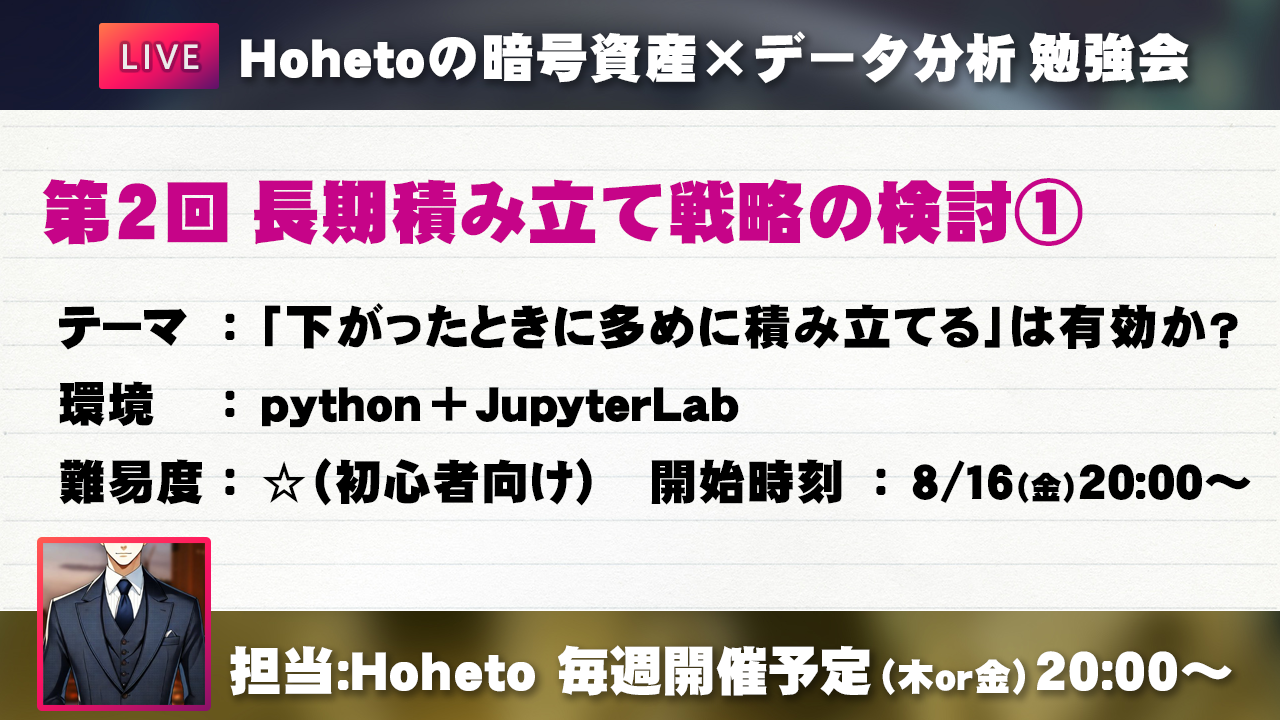

In [1]:
from IPython.display import Image

Image('./images/02_00.png')

# Hoheto勉強会 第2回 長期積み立て戦略の検討①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- 「下がったときの多めに積み立てる」は有効か？
  - 長期的に上がるであろうアセットに「定額ずつ」積み立てるやり方（いわゆるドルコスト平均法）は有効とされている。
  - 価格が普段より下がったタイミングで買う、という戦略はワークするか？しないか？
- 積み立てのパフォーマンスをなんとかして上げる方法はないか？

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- S&Pの日足データの取得方法
- 国内取引所（bitbank）のビットコイン現物の日足データの取得方法
- pandas.DataFrameを使った簡単なバックテストの組み方
- 資産曲線の表示の仕方
- いくつかの積み立て戦略の検討
- など

- 難易度☆1つ。
- ルールベースの戦略をシミュレーションするための基礎的な方法を学びます。

### 元ネタ

- Xはネタの宝庫！今回のネタは・・・

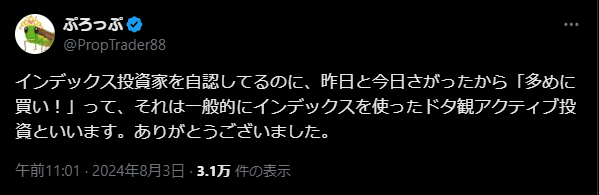

In [2]:
# https://x.com/PropTrader88/status/1819554098779431366
Image('./images/02_01.png')

- 耳が痛いぜ・・・

- 解説すると、
  - 積み立て戦略の前提
    - 「マーケットは長期的（数十年単位）にみて右肩上がりになる」
    - 「マーケットは短期的（数年単位）には読めない（ランダムに上下と仮定）」（読めるならそれに従い売買すれば良い）。
  - ドルコスト平均法による、インデックス積み立て投資
    - 価格を一切考慮せずに、定期的に時間分散をして投資する（売買タイミングを価格変動から独立させる）。
    - これにより短期の値動きリスクを分散させる効果を得る（定期的に入る収入の一部をまわす、というお財布の事情的な側面もある）。
    - ※ドルコスト平均法不要論もある。
  - にも関わらず価格の値動きを見ながら積み立て量を変更するのは、一種のアクティブ運用になってしまう。
    - これは本来、インデックス投資家（パッシブ投資家）の最も嫌うところ。

- とはいえ・・・
  - 積み立てのパフォーマンスをできるだけよくしたいという気持ちはよく分かる。

# 今回の検証の流れ

- 検証①　積み立てで「下がったら多めに買う」を実行すると、どういう結末になるのか？
- 検証②　積み立てのパフォーマンスを上げる方法はあるのか？

# 環境設定

In [3]:
%load_ext autoreload
%autoreload 2

In [32]:
# !pip install japanize-matplotlib
# !pip install tqdm

import japanize_matplotlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import requests
import seaborn as sns
import time
import traceback
import warnings

from datetime import datetime, timedelta
from IPython.display import display, Image
from scipy import stats
from tqdm import tqdm

In [5]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# 検証① 積み立てで「下がったら多めに買う」を実行するとどういう結末になるのか？

## S&Pの例

- 毎月、定期的にS&Pのインデックスに定額を投資しているとする。
- かなり大きめの調整局面が来たら、その時点でいつもより大きな量（Nヶ月分）を購入。
- ただし、投入できる原資の量は変わらない、という前提にするので、その後Nヶ月の定期投資を見送る。

### S&Pのデータ取得

- 直近10年間（2014年以降）のS&Pのデータを取得
- yfinanceライブラリを使用

In [6]:
# !pip install yfinance

import yfinance as yf

# S&P500インデックス価格の取得
sp500 = yf.download('^GSPC', start='2014-01-01', interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [7]:
# データを確認
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,1845.859985,1845.859985,1827.739990,1831.979980,1831.979980,3080600000
2014-01-03,1833.209961,1838.239990,1829.130005,1831.369995,1831.369995,2774270000
2014-01-06,1832.310059,1837.160034,1823.729980,1826.770020,1826.770020,3294850000
2014-01-07,1828.709961,1840.099976,1828.709961,1837.880005,1837.880005,3511750000
2014-01-08,1837.900024,1840.020020,1831.400024,1837.489990,1837.489990,3652140000
...,...,...,...,...,...,...
2024-08-09,5314.660156,5358.669922,5300.839844,5344.160156,5344.160156,3516400000
2024-08-12,5351.879883,5371.200195,5324.370117,5344.390137,5344.390137,3360160000
2024-08-13,5376.979980,5436.500000,5376.979980,5434.430176,5434.430176,3648980000


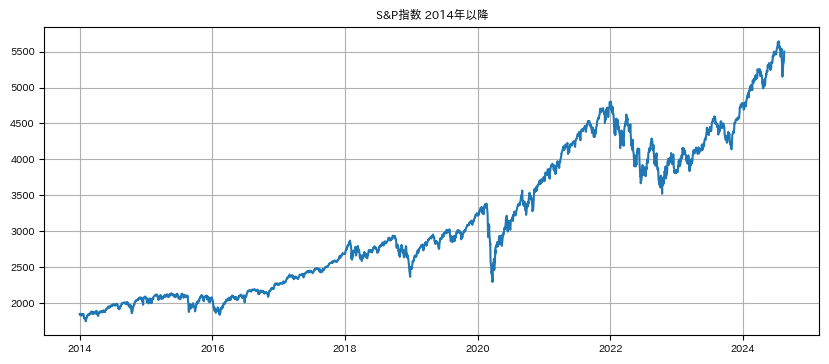

In [8]:
plt.figure(figsize=(10, 4))
plt.title('S&P指数 2014年以降')
plt.plot(sp500['Open'])
plt.grid();

## ベースライン戦略

- 毎月1回、一定額（500ドル）をS&Pに投資する。
- 月初の始値で定額を購入する。
- ※これ以降、コストを全く考慮しない参考値であることに注意。

In [9]:
# 月足を作成.
sp500_base = sp500.resample('MS').agg({'Open': 'first', 'Close': 'last'}).copy()
sp500_base['dollar'] = 500
sp500_base['share'] = sp500_base['dollar'] / sp500_base['Open']
sp500_base['total_dollar'] = sp500_base['dollar'].cumsum()
sp500_base['total_share'] = sp500_base['share'].cumsum()
sp500_base['portfolio_value'] = sp500_base['total_share'] * sp500_base['Open']

In [10]:
sp500_base

,Open,Close,dollar,share,total_dollar,total_share,portfolio_value
Date,,,,,,,
2014-01-01,1845.859985,1782.589966,500,0.270876,500,0.270876,500.000000
2014-02-01,1782.680054,1859.449951,500,0.280477,1000,0.551353,982.886044
2014-03-01,1857.680054,1872.339966,500,0.269153,1500,0.820506,1524.237521
2014-04-01,1873.959961,1883.949951,500,0.266815,2000,1.087321,2037.595282
2014-05-01,1884.390015,1923.569946,500,0.265338,2500,1.352658,2548.936094
...,...,...,...,...,...,...,...
2024-04-01,5257.970215,5035.689941,500,0.095094,62000,22.270344,117096.807990
2024-05-01,5029.029785,5277.509766,500,0.099423,62500,22.369767,112498.225753
2024-06-01,5297.149902,5460.479980,500,0.094390,63000,22.464158,118996.010368


投資総額: $64000.00
評価額　: $125409.01
リターン: 1.9595倍


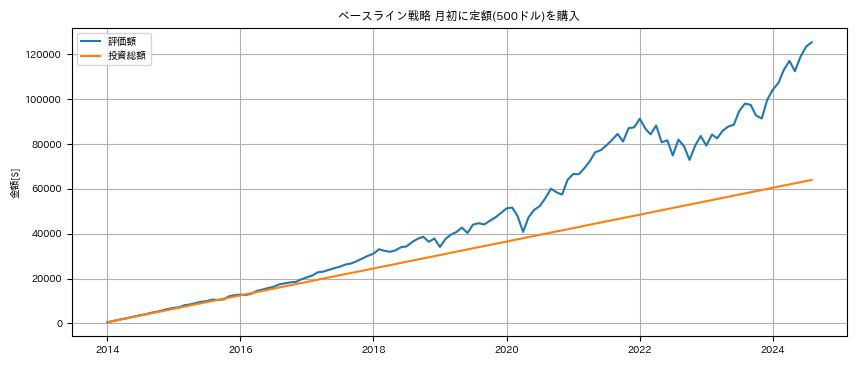

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(sp500_base['portfolio_value'], label='評価額')
plt.plot(sp500_base['total_dollar'], label='投資総額')
plt.title('ベースライン戦略 月初に定額(500ドル)を購入')
plt.ylabel('金額[$]')
plt.legend()
plt.grid();
print(f'投資総額: ${sp500_base["total_dollar"][-1]:.2f}')
print(f'評価額　: ${sp500_base["portfolio_value"][-1]:.2f}')
print(f'リターン: {sp500_base["portfolio_value"][-1]/sp500_base["total_dollar"][-1]:.4f}倍')

## 代替戦略1

- 毎月1回、一定額（500ドル）をS&Pに投資する
- 調整局面が来たとき、
  - その次の日の始値で大きめの量（nヶ月分）を購入する。
  - その後nヶ月の定期投資をスキップする。
- 調整局面とは
  - とりあえず、月初からマイナスm%。
- 調整局面が来なかったら、その月の月末に500ドル分を購入する。

In [12]:
def simulate_sp500_strategy1(data, dollar=500, m=10, n=3):
    dates = data.index
    close_prices = data['Close']
    low_prices = data['Low']
    open_prices = data['Open']
    portfolio_value = []
    total_dollars = []
    cumulative_shares = 0
    cumulative_dollars = 0
    monthly_close = close_prices.resample('M').last()
    monthly_start = open_prices.resample('M').first()
    skip_until = None
    for month in monthly_start.index:
        if skip_until and month < skip_until:
            portfolio_value.append(cumulative_shares * monthly_close[month])
            total_dollars.append(cumulative_dollars)
            continue
        purchase_made = False
        # 月内でm%以上下がった日があるか確認
        for day in dates[(dates >= month) & (dates < month + pd.DateOffset(months=1))]:
            if (monthly_start[month] - low_prices[day]) / monthly_start[month] >= m / 100:
                # nヵ月分まとめて購入
                cumulative_shares += (n * dollar) / close_prices[day]
                cumulative_dollars += n * dollar
                portfolio_value.append(cumulative_shares * close_prices[day])
                total_dollars.append(cumulative_dollars)
                purchase_made = True
                skip_until = month + pd.DateOffset(months=n)
                break
        # m%以上下がった日がない場合、月末に購入
        if not purchase_made:
            end_price = monthly_close[month]
            cumulative_shares += dollar / end_price
            cumulative_dollars += dollar
            portfolio_value.append(cumulative_shares * end_price)
            total_dollars.append(cumulative_dollars)
    return pd.DataFrame({'total_dollar': total_dollars, 'portfolio_value': portfolio_value}, index=monthly_start.index)[:'2024-07']

### n=3か月分をまとめて投資。調整幅m=10, 15, 20, 25%

baseline  : 原資=64000, 評価額=125409, パフォーマンス=195.95%
m=10%     : 原資=63500, 評価額=124449, パフォーマンス=195.98%
m=15%     : 原資=63500, 評価額=123751, パフォーマンス=194.88%
m=20%     : 原資=63500, 評価額=124033, パフォーマンス=195.33%
m=25%     : 原資=63500, 評価額=124165, パフォーマンス=195.54%


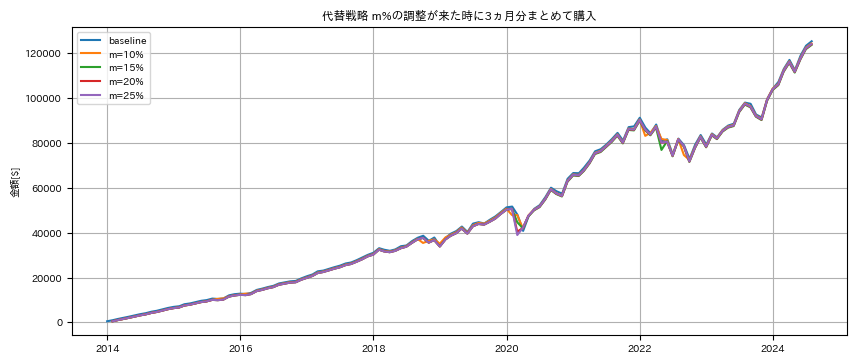

In [13]:
sp500_stg1 = sp500.copy()
simulation_results = {}
thresholds = [10, 15, 20, 25]

simulation_results['baseline'] =sp500_base
for threshold in thresholds:
    simulation_results[f'm={threshold}%'] = simulate_sp500_strategy1(sp500_stg1, dollar=500, m=threshold, n=3)

plt.figure(figsize=(10, 4))
for key, result in simulation_results.items():
    plt.plot(result['portfolio_value'], label=key)
    print(f'{key:10}: 原資={result["total_dollar"][-1]:.0f}, 評価額={result["portfolio_value"][-1]:.0f}, パフォーマンス={result["portfolio_value"][-1] / result["total_dollar"][-1] * 100:.2f}%')

plt.title('代替戦略 m%の調整が来た時に3ヵ月分まとめて購入')
plt.ylabel('金額[$]')
plt.legend()
plt.grid(True)
plt.show()

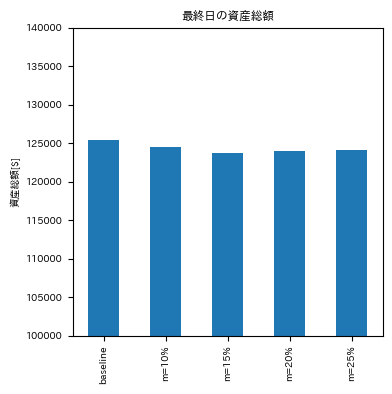

In [14]:
pd.Series({key: result['portfolio_value'][-1] for key, result in simulation_results.items()}).plot(kind='bar');
plt.ylim(100000, 140000)
plt.title('最終日の資産総額')
plt.ylabel('資産総額[$]');

### 調整幅m=10%で、n=2, 3, 4, 5か月分をまとめて投資。

baseline  : 原資=64000, 評価額=125409, パフォーマンス=195.95%
N=2months : 原資=63500, 評価額=124483, パフォーマンス=196.04%
N=3months : 原資=63500, 評価額=124449, パフォーマンス=195.98%
N=4months : 原資=63500, 評価額=124764, パフォーマンス=196.48%
N=5months : 原資=63500, 評価額=124918, パフォーマンス=196.72%


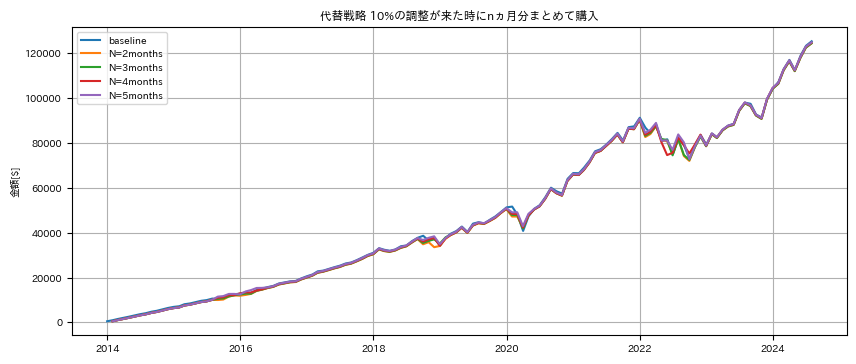

In [15]:
sp500_stg2 = sp500.copy()
simulation_results = {}
months = [2, 3, 4, 5]

simulation_results['baseline'] =sp500_base
for month in months:
    simulation_results[f'N={month}months'] = simulate_sp500_strategy1(sp500_stg2, dollar=500, m=10, n=month)

plt.figure(figsize=(10, 4))
for key, result in simulation_results.items():
    plt.plot(result['portfolio_value'], label=key)
    print(f'{key:10}: 原資={result["total_dollar"][-1]:.0f}, 評価額={result["portfolio_value"][-1]:.0f}, パフォーマンス={result["portfolio_value"][-1] / result["total_dollar"][-1] * 100:.2f}%')

plt.title('代替戦略 10%の調整が来た時にnヵ月分まとめて購入')
plt.ylabel('金額[$]')
plt.legend()
plt.grid(True)
plt.show()

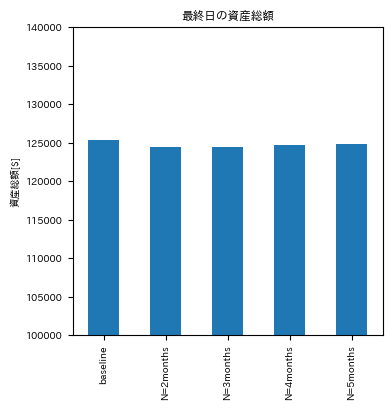

In [16]:
pd.Series({key: result['portfolio_value'][-1] for key, result in simulation_results.items()}).plot(kind='bar');
plt.ylim(100000, 140000)
plt.title('最終日の資産総額')
plt.ylabel('資産総額[$]');

## 結論

- 積み立てで「下がったら多めに買う」を実行するとどういう結末になるのか？　→　ほとんど影響ない

- そもそも「大きな調整局面」の回数が少ない。
- こういうタイミングで裁量で多く買っても、長期的に見ると影響は小さい。つまりやってもやらなくても大して変わらない。
- それよりも、「積み立てる」という大枠を決定していることが重要。
- これは積み立て（というより取引回数を多くすること）のメリットの1つ。1回や2回間違った行動をとっても、全体への影響は軽微で抑えられる。

# ではどうする

- めったにない局面で積立額を増減しても、全体のパフォーマンスへの影響は限定的。
- 全体に渡って平均取得価格を下げる工夫が必要となる。

# 検証② 積み立てのパフォーマンスを上げる方法はあるのか？

- ここからはビットコイン積み立ての例で。

## ビットコイン現物のデータ取得（bitbank）

- 2018年から参入、というシナリオで。
- 指標計算用に2017年からデータ取得。

In [17]:
import requests

df_list = []
for year in range(2017, 2025):
    j = requests.get(f'https://public.bitbank.cc/btc_jpy/candlestick/1day/{year}').json()
    btcjpy = pd.DataFrame(j['data']['candlestick'][0]['ohlcv'], columns=['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'time'], dtype=float)
    btcjpy.index = pd.to_datetime(btcjpy['time'] / 1000, unit='s')
    df_list.append(btcjpy)

btcjpy = pd.concat(df_list, axis=0)

In [18]:
btcjpy

,open_price,high_price,low_price,close_price,volume,time
time,,,,,,
2017-01-02,119434.0,119434.0,118782.0,118933.0,0.0000,1.483315e+12
2017-01-03,118699.0,122223.0,117386.0,121781.0,0.0000,1.483402e+12
2017-01-04,122134.0,133828.0,121520.0,130487.0,0.0000,1.483488e+12
2017-01-05,129670.0,132528.0,102854.0,115894.0,0.0000,1.483574e+12
2017-01-06,116272.0,119052.0,101044.0,104572.0,0.0000,1.483661e+12
...,...,...,...,...,...,...
2024-08-12,8650375.0,8968384.0,8500000.0,8731070.0,269.2694,1.723421e+12
2024-08-13,8731070.0,9035788.0,8657130.0,8899039.0,200.7975,1.723507e+12
2024-08-14,8899388.0,9100000.0,8635801.0,8677775.0,241.0516,1.723594e+12


In [19]:
# 欠損チェック
btcjpy.isnull().any()

open_price     False
high_price     False
low_price      False
close_price    False
volume         False
time           False
dtype: bool

In [20]:
# 超副業のチェック
btcjpy[btcjpy.index.duplicated()]

,open_price,high_price,low_price,close_price,volume,time
time,,,,,,
2017-05-29,273000.0,273000.0,273000.0,273000.0,0.0,1.496016e+12


In [21]:
# 重複行を削除
btcjpy = btcjpy[~btcjpy.index.duplicated()]

In [22]:
# 抜け漏れチェック
datetime_index_full = pd.DatetimeIndex(pd.date_range(start=btcjpy.index.min(), end=btcjpy.index.max(), freq='1d'))
missing_index = datetime_index_full.difference(btcjpy.index)
len(missing_index)

0

## ベースライン戦略

- 毎日積み立て。

In [23]:
btcjpy_base = btcjpy.copy()
btcjpy_base = btcjpy_base['2018':]
btcjpy_base['yen'] = 1000
btcjpy_base['btc'] = btcjpy_base['yen'] / btcjpy_base['open_price']
btcjpy_base['total_yen'] = btcjpy_base['yen'].cumsum()
btcjpy_base['total_btc'] = btcjpy_base['btc'].cumsum()
btcjpy_base['portfolio_value'] = btcjpy_base['total_btc'] * btcjpy_base['open_price']

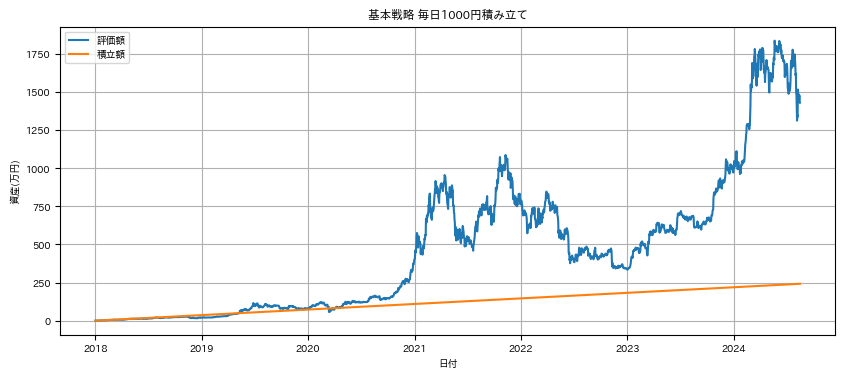

ベースライン: 原資=2420000, 評価額=14294015, パフォーマンス=590.66%


In [24]:
plt.figure(figsize=(10, 4))
plt.plot(btcjpy_base['portfolio_value'] / 10000, label='評価額')
plt.plot(btcjpy_base['total_yen'] / 10000, label='積立額')
plt.title('基本戦略 毎日1000円積み立て')
plt.xlabel('日付')
plt.ylabel('資産(万円)')
plt.legend()
plt.grid(True)
plt.show()
print(f'ベースライン: 原資={btcjpy_base["total_yen"][-1]:.0f}, 評価額={btcjpy_base["portfolio_value"][-1]:.0f}, パフォーマンス={btcjpy_base["portfolio_value"][-1] / btcjpy_base["total_yen"][-1] * 100:.2f}%')

## 戦略検討

- 平均取得価格を下げるには、価格が低いと考えられる水準で多めに購入し、高いと考えられる水準で少なめに購入する。
- 候補となる戦略
  - テクニカル系
    - 移動平均との比較
    - オシレータ系指標（RSIなど）
  - ファンダメンタル系
    - ハッシュレート、マイニング難易度
    - 半減期
    - オンチェーンデータ
    - 規制・イベント
    - ETF
  - 市場のセンチメント系
    - Funding Rate
    - Open Interest
    - 恐怖指数

## 戦略1. 200日移動平均線に応じて積立金額を変える

- 以下の金額を毎日積み立てる
  - 価格が200日移動平均線を下回っているときは、1000＋α 円
  - 価格が200日移動平均線を下回っているときは、1000－α 円

In [27]:
btcjpy_stg1 = btcjpy.copy()
btcjpy_stg1['sma200_s1'] = btcjpy_stg1['close_price'].rolling(200).mean().shift(1)
btcjpy_stg1 = btcjpy_stg1['2018':]
btcjpy_stg1['yen'] = 1000
btcjpy_stg1.loc[btcjpy_stg1['open_price'] >= btcjpy_stg1['sma200_s1'], 'yen'] = 500
btcjpy_stg1.loc[btcjpy_stg1['open_price'] < btcjpy_stg1['sma200_s1'], 'yen'] = 1500
btcjpy_stg1['btc'] = btcjpy_stg1['yen'] / btcjpy_stg1['open_price']
btcjpy_stg1['total_yen'] = btcjpy_stg1['yen'].cumsum()
btcjpy_stg1['total_btc'] = btcjpy_stg1['btc'].cumsum()
btcjpy_stg1['portfolio_value'] = btcjpy_stg1['total_btc'] * btcjpy_stg1['open_price']

ベースライン: 原資=2420000, 評価額=14294015, パフォーマンス=590.66%
戦略1       : 原資=2271000, 評価額=15826696, パフォーマンス=696.90%


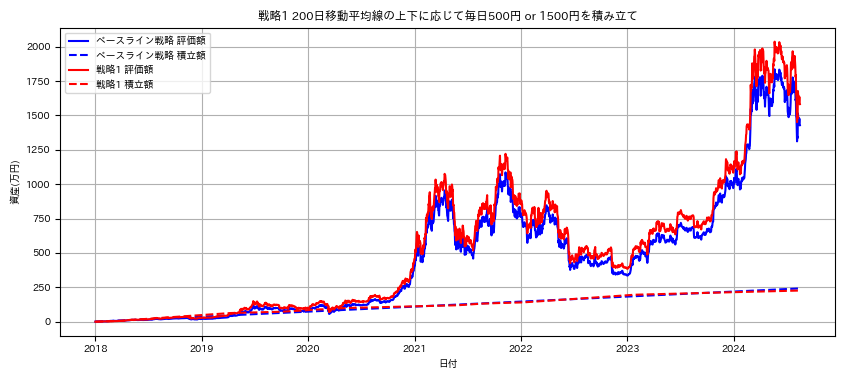

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(btcjpy_base['portfolio_value'] / 10000, label='ベースライン戦略 評価額', color='blue')
plt.plot(btcjpy_base['total_yen'] / 10000, label='ベースライン戦略 積立額', color='blue', linestyle='--')
plt.plot(btcjpy_stg1['portfolio_value'] / 10000, label='戦略1 評価額', color='red')
plt.plot(btcjpy_stg1['total_yen'] / 10000, label='戦略1 積立額', color='red', linestyle='--')
plt.title('戦略1 200日移動平均線の上下に応じて毎日500円 or 1500円を積み立て')
plt.xlabel('日付')
plt.ylabel('資産(万円)')
plt.legend()
plt.grid(True);
print(f'ベースライン: 原資={btcjpy_base["total_yen"][-1]:.0f}, 評価額={btcjpy_base["portfolio_value"][-1]:.0f}, パフォーマンス={btcjpy_base["portfolio_value"][-1] / btcjpy_base["total_yen"][-1] * 100:.2f}%')
print(f'戦略1       : 原資={btcjpy_stg1["total_yen"][-1]:.0f}, 評価額={btcjpy_stg1["portfolio_value"][-1]:.0f}, パフォーマンス={btcjpy_stg1["portfolio_value"][-1] / btcjpy_stg1["total_yen"][-1] * 100:.2f}%')

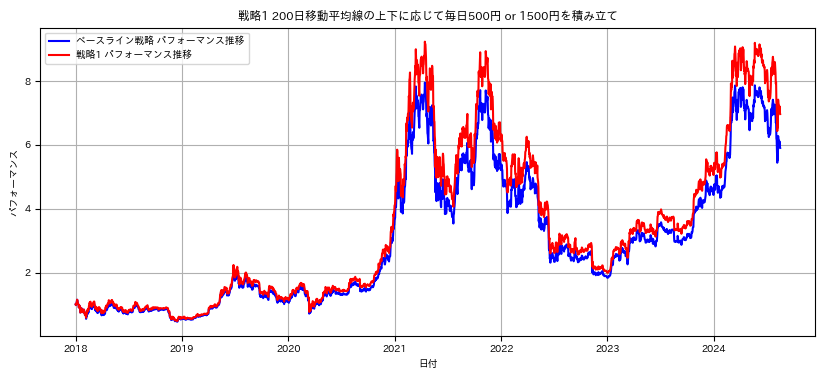

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(btcjpy_base['portfolio_value'] / btcjpy_base['total_yen'], label='ベースライン戦略 パフォーマンス推移', color='blue')
plt.plot(btcjpy_stg1['portfolio_value'] / btcjpy_stg1['total_yen'], label='戦略1 パフォーマンス推移', color='red')
plt.title('戦略1 200日移動平均線の上下に応じて毎日500円 or 1500円を積み立て')
plt.xlabel('日付')
plt.ylabel('パフォーマンス')
plt.legend()
plt.grid(True);

### 積立金額別に期間を確認してみる

- アウトパフォームしている要因としては、
  - 200日線より下の期間が一定以上ある。
  - 対象期間の前半で200日線より下の期間が多かった。

In [30]:
btcjpy_stg1['under_200sma'] = (btcjpy_stg1['open_price'] < btcjpy_stg1['sma200_s1']).astype(int)
btcjpy_stg1['cross_200sma'] = (btcjpy_stg1['under_200sma'].diff() != 0).astype(int)
cross_dates = btcjpy_stg1[btcjpy_stg1['cross_200sma'] == 1].index.to_series()

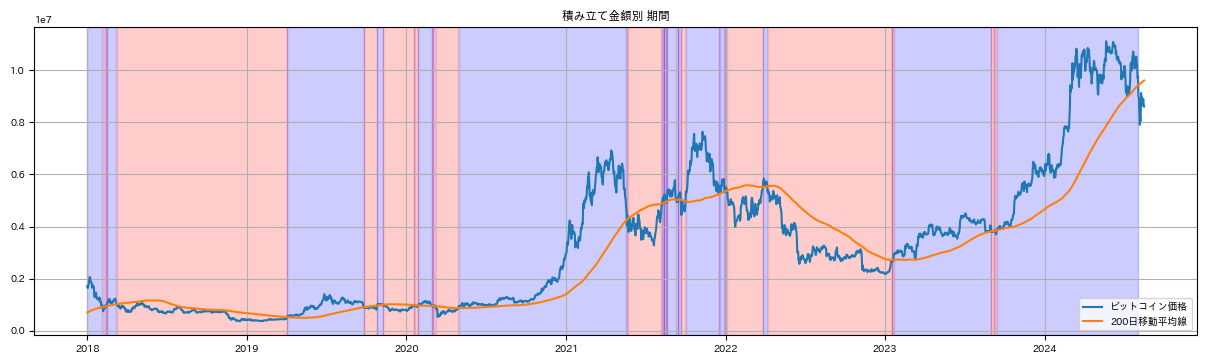

In [33]:
plt.figure(figsize=(15, 4))
ax = plt.gca()

for i in range(len(cross_dates)-1):
    ax.axvspan(cross_dates[i], cross_dates[i+1]-timedelta(days=1), color='blue' if i % 2 == 0 else 'red', alpha=0.2)

plt.title('積み立て金額別 期間')
plt.plot(btcjpy_stg1['open_price'], label='ビットコイン価格')
plt.plot(btcjpy_stg1['sma200_s1'], label='200日移動平均線')
plt.legend()
plt.grid();

### 注意点1 開始時期によるパフォーマンスの劣化

- 2023年から積み立てを開始した例
- ほとんどの期間がSMA200よりも上であるため、積立額が少なくなってしまう

In [34]:
btcjpy_2023 = btcjpy.copy()
btcjpy_2023 = btcjpy_2023['2023':]
btcjpy_2023['yen'] = 1000
btcjpy_2023['btc'] = btcjpy_2023['yen'] / btcjpy_2023['open_price']
btcjpy_2023['total_yen'] = btcjpy_2023['yen'].cumsum()
btcjpy_2023['total_btc'] = btcjpy_2023['btc'].cumsum()
btcjpy_2023['portfolio_value'] = btcjpy_2023['total_btc'] * btcjpy_2023['open_price']

btcjpy_2023_stg1 = btcjpy.copy()
btcjpy_2023_stg1['sma200_s1'] = btcjpy_2023_stg1['close_price'].rolling(200).mean().shift(1)
btcjpy_2023_stg1 = btcjpy_2023_stg1['2023':]
btcjpy_2023_stg1['yen'] = 1000
btcjpy_2023_stg1.loc[btcjpy_2023_stg1['open_price'] >= btcjpy_2023_stg1['sma200_s1'], 'yen'] = 500
btcjpy_2023_stg1.loc[btcjpy_2023_stg1['open_price'] < btcjpy_2023_stg1['sma200_s1'], 'yen'] = 1500
btcjpy_2023_stg1['btc'] = btcjpy_2023_stg1['yen'] / btcjpy_2023_stg1['open_price']
btcjpy_2023_stg1['total_yen'] = btcjpy_2023_stg1['yen'].cumsum()
btcjpy_2023_stg1['total_btc'] = btcjpy_2023_stg1['btc'].cumsum()
btcjpy_2023_stg1['portfolio_value'] = btcjpy_2023_stg1['total_btc'] * btcjpy_2023_stg1['open_price']

ベースライン: 原資=594000, 評価額=1036272, パフォーマンス=174.46%
戦略1       : 原資=342000, 評価額=628333, パフォーマンス=183.72%


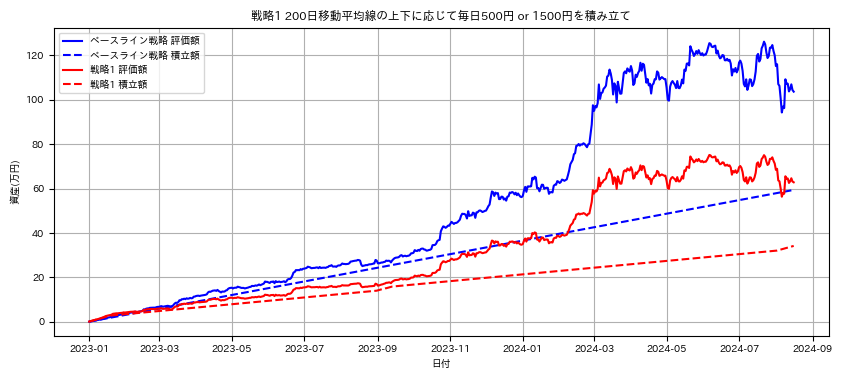

In [35]:
plt.figure(figsize=(10, 4))
plt.plot(btcjpy_2023['portfolio_value'] / 10000, label='ベースライン戦略 評価額', color='blue')
plt.plot(btcjpy_2023['total_yen'] / 10000, label='ベースライン戦略 積立額', color='blue', linestyle='--')
plt.plot(btcjpy_2023_stg1['portfolio_value'] / 10000, label='戦略1 評価額', color='red')
plt.plot(btcjpy_2023_stg1['total_yen'] / 10000, label='戦略1 積立額', color='red', linestyle='--')
plt.title('戦略1 200日移動平均線の上下に応じて毎日500円 or 1500円を積み立て')
plt.xlabel('日付')
plt.ylabel('資産(万円)')
plt.legend()
plt.grid(True);
print(f'ベースライン: 原資={btcjpy_2023["total_yen"][-1]:.0f}, 評価額={btcjpy_2023["portfolio_value"][-1]:.0f}, パフォーマンス={btcjpy_2023["portfolio_value"][-1] / btcjpy_2023["total_yen"][-1] * 100:.2f}%')
print(f'戦略1       : 原資={btcjpy_2023_stg1["total_yen"][-1]:.0f}, 評価額={btcjpy_2023_stg1["portfolio_value"][-1]:.0f}, パフォーマンス={btcjpy_2023_stg1["portfolio_value"][-1] / btcjpy_2023_stg1["total_yen"][-1] * 100:.2f}%')

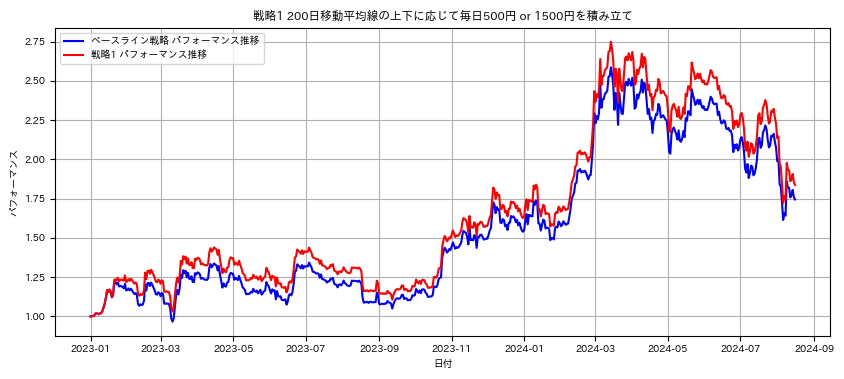

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(btcjpy_2023['portfolio_value'] / btcjpy_2023['total_yen'], label='ベースライン戦略 パフォーマンス推移', color='blue')
plt.plot(btcjpy_2023_stg1['portfolio_value'] / btcjpy_2023_stg1['total_yen'], label='戦略1 パフォーマンス推移', color='red')
plt.title('戦略1 200日移動平均線の上下に応じて毎日500円 or 1500円を積み立て')
plt.xlabel('日付')
plt.ylabel('パフォーマンス')
plt.legend()
plt.grid(True);

### 注意点2 原資産のチャートによる違い

- S&Pの例。
- 同じくほとんどの期間がSMA200よりも上であるため、積立額が少なくなってしまう

In [37]:
sp500_base = sp500.copy()
sp500_base = sp500_base['2015':]
sp500_base['dollar'] = 10
sp500_base['share'] = sp500_base['dollar'] / sp500_base['Open']
sp500_base['total_dollar'] = sp500_base['dollar'].cumsum()
sp500_base['total_share'] = sp500_base['share'].cumsum()
sp500_base['portfolio_value'] = sp500_base['total_share'] * sp500_base['Open']

sp500_stg1 = sp500.copy()
sp500_stg1['sma200_s1'] = sp500_stg1['Close'].rolling(200).mean().shift(1)
sp500_stg1 = sp500_stg1['2015':]
sp500_stg1['dollar'] = 00
sp500_stg1.loc[sp500_stg1['Open'] >= sp500_stg1['sma200_s1'], 'dollar'] = 5
sp500_stg1.loc[sp500_stg1['Open'] < sp500_stg1['sma200_s1'], 'dollar'] = 15
sp500_stg1['share'] = sp500_stg1['dollar'] / sp500_stg1['Open']
sp500_stg1['total_dollar'] = sp500_stg1['dollar'].cumsum()
sp500_stg1['total_share'] = sp500_stg1['share'].cumsum()
sp500_stg1['portfolio_value'] = sp500_stg1['total_share'] * sp500_stg1['Open']

ベースライン: 原資=24210, 評価額=44728, パフォーマンス=184.75%
戦略1       : 原資=17045, 評価額=31765, パフォーマンス=186.36%


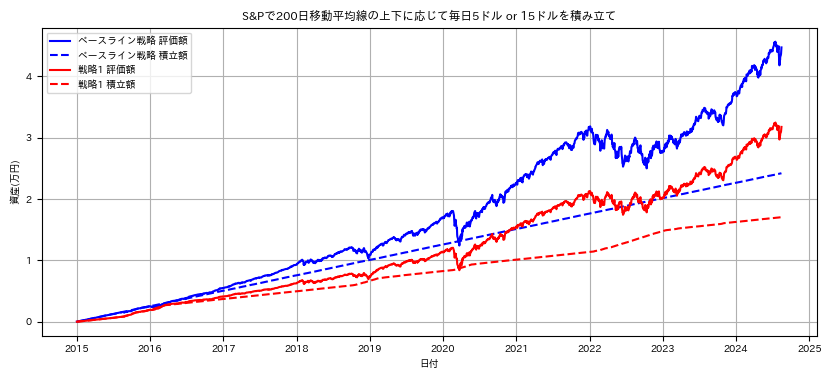

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(sp500_base['portfolio_value'] / 10000, label='ベースライン戦略 評価額', color='blue')
plt.plot(sp500_base['total_dollar'] / 10000, label='ベースライン戦略 積立額', color='blue', linestyle='--')
plt.plot(sp500_stg1['portfolio_value'] / 10000, label='戦略1 評価額', color='red')
plt.plot(sp500_stg1['total_dollar'] / 10000, label='戦略1 積立額', color='red', linestyle='--')
plt.title('S&Pで200日移動平均線の上下に応じて毎日5ドル or 15ドルを積み立て')
plt.xlabel('日付')
plt.ylabel('資産(万円)')
plt.legend()
plt.grid(True);
print(f'ベースライン: 原資={sp500_base["total_dollar"][-1]:.0f}, 評価額={sp500_base["portfolio_value"][-1]:.0f}, パフォーマンス={sp500_base["portfolio_value"][-1] / sp500_base["total_dollar"][-1] * 100:.2f}%')
print(f'戦略1       : 原資={sp500_stg1["total_dollar"][-1]:.0f}, 評価額={sp500_stg1["portfolio_value"][-1]:.0f}, パフォーマンス={sp500_stg1["portfolio_value"][-1] / sp500_stg1["total_dollar"][-1] * 100:.2f}%')

- 積立金額別に期間を確認してみる

In [39]:
sp500_stg1['under_200sma'] = (sp500_stg1['Open'] < sp500_stg1['sma200_s1']).astype(int)
sp500_stg1['cross_200sma'] = (sp500_stg1['under_200sma'].diff() != 0).astype(int)
cross_dates = sp500_stg1[sp500_stg1['cross_200sma'] == 1].index.to_series()

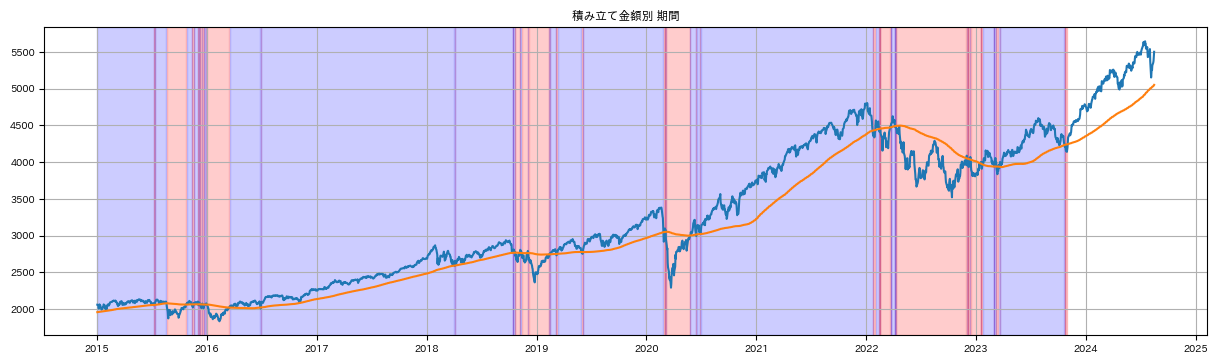

In [40]:
plt.figure(figsize=(15, 4))
ax = plt.gca()

for i in range(len(cross_dates)-1):
    ax.axvspan(cross_dates[i], cross_dates[i+1]-timedelta(days=1), color='blue' if i % 2 == 0 else 'red', alpha=0.2)

plt.title('積み立て金額別 期間')
plt.plot(sp500_stg1['Open'])
plt.plot(sp500_stg1['sma200_s1'])
plt.grid();

## 戦略2. FundingRateに応じて積立金額を変える

- 以下の金額を毎日積み立てる
  - Funding Rateがマイナスのときは、1000＋α 円
  - Funding Rateがプラスのときは、1000－α 円

### BitMEXからFunding Rateの過去データを取得

In [41]:
start = 0
limit = 500
result = []
while True:
    j = requests.get(f'https://www.bitmex.com/api/v1/funding?count={limit}&start={start}&reverse=true&filter=%7B%22symbol%22%3A%22XBTUSD%22%7D&type=funding').json()
    print('fetching...', j[0])
    result += j
    start += len(j)
    time.sleep(1)
    if len(j) < limit:
        break


fetching... {'timestamp': '2024-08-16T04:00:00.000Z', 'symbol': 'XBTUSD', 'fundingInterval': '2000-01-01T08:00:00.000Z', 'fundingRate': 0.0001, 'fundingRateDaily': 0.00030000000000000003}
fetching... {'timestamp': '2024-03-02T12:00:00.000Z', 'symbol': 'XBTUSD', 'fundingInterval': '2000-01-01T08:00:00.000Z', 'fundingRate': 0.0001, 'fundingRateDaily': 0.00030000000000000003}
fetching... {'timestamp': '2023-09-17T20:00:00.000Z', 'symbol': 'XBTUSD', 'fundingInterval': '2000-01-01T08:00:00.000Z', 'fundingRate': -0.000151, 'fundingRateDaily': -0.00045300000000000006}
fetching... {'timestamp': '2023-04-04T04:00:00.000Z', 'symbol': 'XBTUSD', 'fundingInterval': '2000-01-01T08:00:00.000Z', 'fundingRate': 4.4e-05, 'fundingRateDaily': 0.000132}
fetching... {'timestamp': '2022-10-19T12:00:00.000Z', 'symbol': 'XBTUSD', 'fundingInterval': '2000-01-01T08:00:00.000Z', 'fundingRate': 0.0001, 'fundingRateDaily': 0.00030000000000000003}
fetching... {'timestamp': '2022-05-05T20:00:00.000Z', 'symbol': 'XBTU

In [42]:
bitmex_fr = pd.DataFrame(result)
bitmex_fr.index = pd.to_datetime(bitmex_fr['timestamp'])
bitmex_fr = bitmex_fr.drop(['timestamp', 'symbol', 'fundingInterval'], axis=1).astype(float).sort_index()
bitmex_fr = bitmex_fr['2018':]

In [43]:
bitmex_fr

,fundingRate,fundingRateDaily
timestamp,,
2018-01-01 04:00:00+00:00,0.001169,0.003507
2018-01-01 12:00:00+00:00,0.001293,0.003879
2018-01-01 20:00:00+00:00,0.000815,0.002445
2018-01-02 04:00:00+00:00,-0.000467,-0.001401
2018-01-02 12:00:00+00:00,0.001980,0.005940
...,...,...
2024-08-14 20:00:00+00:00,0.000082,0.000246
2024-08-15 04:00:00+00:00,0.000094,0.000282
2024-08-15 12:00:00+00:00,0.000100,0.000300


### 内容確認

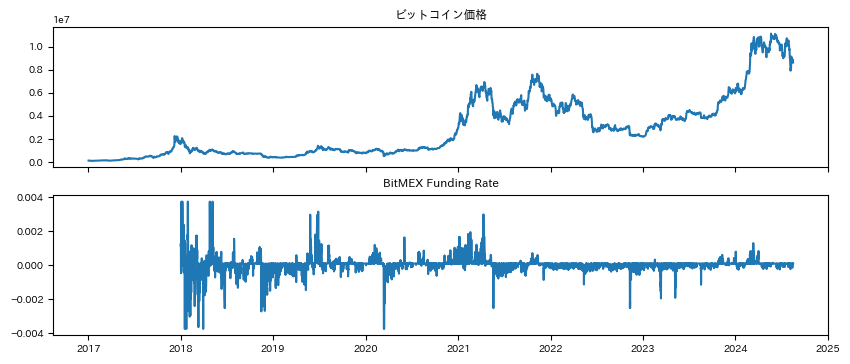

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax[0].plot(btcjpy['open_price'])
ax[0].set_title('ビットコイン価格')
ax[1].plot(bitmex_fr['fundingRate'])
ax[1].set_title('BitMEX Funding Rate');

### 日足を作成＆FundingRateの符号

In [45]:
bitmex_fr_1d = bitmex_fr.resample('1d').mean()
bitmex_fr_1d['fr_sign'] = np.sign(bitmex_fr_1d['fundingRate'])
bitmex_fr_1d.index = bitmex_fr_1d.index.to_period('d').to_timestamp()

In [46]:
bitmex_fr_1d

,fundingRate,fundingRateDaily,fr_sign
timestamp,,,
2018-01-01,0.001092,0.003277,1.0
2018-01-02,0.000704,0.002113,1.0
2018-01-03,0.003266,0.009798,1.0
2018-01-04,0.001296,0.003889,1.0
2018-01-05,0.001758,0.005274,1.0
...,...,...,...
2024-08-12,0.000100,0.000300,1.0
2024-08-13,0.000018,0.000053,1.0
2024-08-14,0.000094,0.000282,1.0


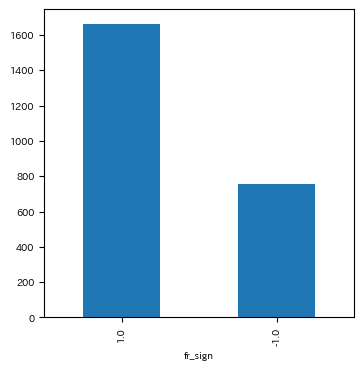

In [54]:
bitmex_fr_1d['fr_sign'].value_counts().plot(kind='bar');

In [48]:
btcjpy_stg2 = btcjpy.copy()
btcjpy_stg2['fr_sign_s1'] = bitmex_fr_1d['fr_sign'].shift(1)
btcjpy_stg2 = btcjpy_stg2['2018':]
btcjpy_stg2['yen'] = 1000
btcjpy_stg2.loc[btcjpy_stg2['fr_sign_s1'] == 1, 'yen'] = 500
btcjpy_stg2.loc[btcjpy_stg2['fr_sign_s1'] == -1, 'yen'] = 1500
btcjpy_stg2['btc'] = btcjpy_stg2['yen'] / btcjpy_stg2['open_price']
btcjpy_stg2['total_yen'] = btcjpy_stg2['yen'].cumsum()
btcjpy_stg2['total_btc'] = btcjpy_stg2['btc'].cumsum()
btcjpy_stg2['portfolio_value'] = btcjpy_stg2['total_btc'] * btcjpy_stg2['open_price']

ベースライン: 原資=2420000, 評価額=14294015, パフォーマンス=590.66%
戦略2       : 原資=1968500, 評価額=12951796, パフォーマンス=657.95%


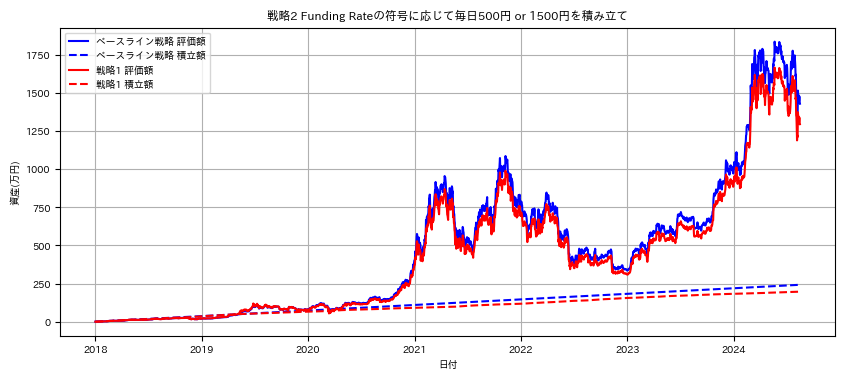

In [49]:
plt.figure(figsize=(10, 4))
plt.plot(btcjpy_base['portfolio_value'] / 10000, label='ベースライン戦略 評価額', color='blue')
plt.plot(btcjpy_base['total_yen'] / 10000, label='ベースライン戦略 積立額', color='blue', linestyle='--')
plt.plot(btcjpy_stg2['portfolio_value'] / 10000, label='戦略1 評価額', color='red')
plt.plot(btcjpy_stg2['total_yen'] / 10000, label='戦略1 積立額', color='red', linestyle='--')
plt.title('戦略2 Funding Rateの符号に応じて毎日500円 or 1500円を積み立て')
plt.xlabel('日付')
plt.ylabel('資産(万円)')
plt.legend()
plt.grid(True);
print(f'ベースライン: 原資={btcjpy_base["total_yen"][-1]:.0f}, 評価額={btcjpy_base["portfolio_value"][-1]:.0f}, パフォーマンス={btcjpy_base["portfolio_value"][-1] / btcjpy_base["total_yen"][-1] * 100:.2f}%')
print(f'戦略2       : 原資={btcjpy_stg2["total_yen"][-1]:.0f}, 評価額={btcjpy_stg2["portfolio_value"][-1]:.0f}, パフォーマンス={btcjpy_stg2["portfolio_value"][-1] / btcjpy_stg2["total_yen"][-1] * 100:.2f}%')

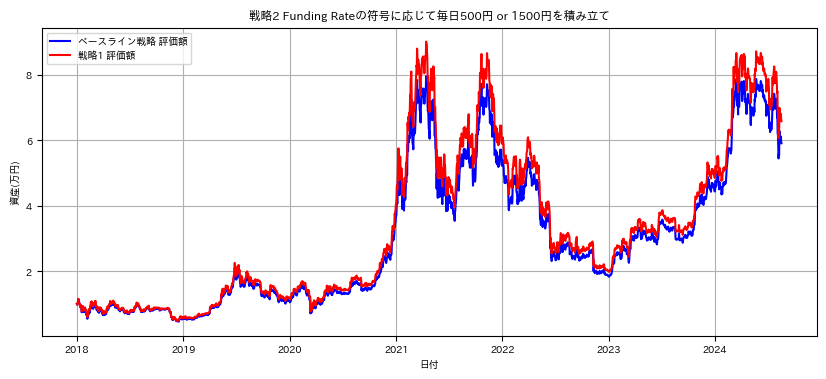

In [50]:
plt.figure(figsize=(10, 4))
plt.plot(btcjpy_base['portfolio_value'] / btcjpy_base['total_yen'], label='ベースライン戦略 評価額', color='blue')
plt.plot(btcjpy_stg2['portfolio_value'] / btcjpy_stg2['total_yen'], label='戦略1 評価額', color='red')
plt.title('戦略2 Funding Rateの符号に応じて毎日500円 or 1500円を積み立て')
plt.xlabel('日付')
plt.ylabel('資産(万円)')
plt.legend()
plt.grid(True);

In [51]:
btcjpy_stg2['change_fr_sign_s1'] = (btcjpy_stg2['fr_sign_s1'].diff() != 0).astype(int)
cross_dates = btcjpy_stg2[btcjpy_stg2['change_fr_sign_s1'] == 1].index.to_series()

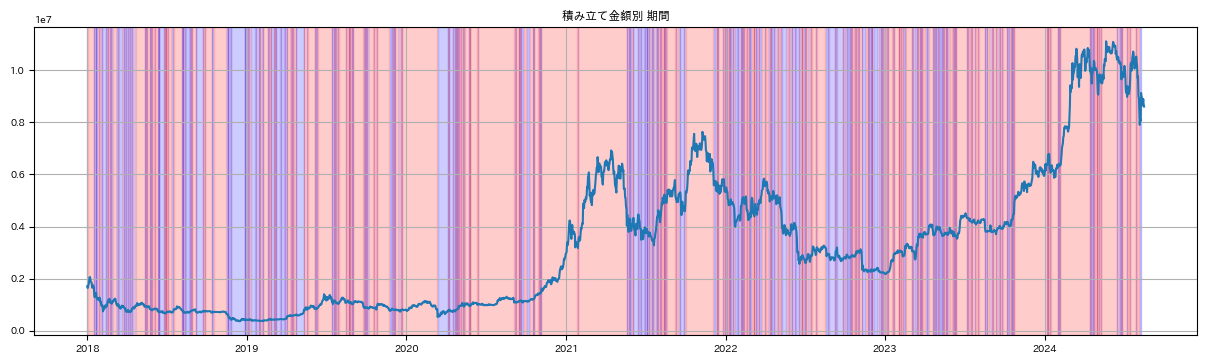

In [52]:
plt.figure(figsize=(15, 4))
ax = plt.gca()

for i in range(len(cross_dates)-1):
    ax.axvspan(cross_dates[i], cross_dates[i+1]-timedelta(days=1), color='blue' if i % 2 == 0 else 'red', alpha=0.2)

plt.title('積み立て金額別 期間')
plt.plot(btcjpy_stg2['open_price'])
plt.grid();

# まとめ

- 「価格が低いと考えられる水準で多めに購入し、高いと考えられる水準で少なめに購入する」というやり方で、積み立てのパフォーマンスを上げられる可能性がある。
  - その際、テクニカルや市場センチメントなどの指標が考えられる。
  - 200日移動平均線やFunding Rateを使った戦略は、バックテスト上では良好に機能した。
- 長期積み立て戦略についての今後の検証予定
  - 執行の時刻や方法についての検証
  - ETHなどのアルトコインを絡めたときの検証


# 次回のネタ

- 恐怖指数